<div class="alert alert-block alert-info">

# D3 Layout Study - Part 2
This notebook is the second in a series of notebooks intended to:
1. Demonstrate the use and relationships of layout with respect to margins, and scaling and positioning in a D3 visualization
2. Study how the the D3 visualization components can be extracted using Seleniums python API

**In part 2**, we study how visual encodings, such as rects, circles, are positioned in the plot using the scales we defined in part 1. 

### Use
Before running the cells in this notebook, start a local server on `port=3000` in the `viz/` directory 

_e.g.,_ `python3 -m http.server 3000 &`

### D3 Examples
All example D3 visualizations are located in the `viz/` directory.
</div>

In [1]:
from selenium import webdriver
import numpy as np
import pandas as pd

#### Render Page (following our convention from Part 1)

<div class="alert alert-block alert-info">
* for this section, study the source under `viz/visual_encodings_position_study.html` and data from `viz/data/data1.csv`
</div>

Insantiate a Chrome webdriver and load the page. Adjust the window size of the webdriver to be the size of the rendered page to avoid clipping content from view.

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
driver = webdriver.Chrome(
    executable_path="../bin/chromedriver",
    options=chrome_options)
url = 'http://localhost:3000/visual_encodings_position_study.html'
driver.get(url)  # must be running a localserver in the viz/ dir
rendered_width = driver.execute_script("return document.documentElement.scrollWidth")
rendered_height = driver.execute_script("return document.documentElement.scrollHeight")
driver.set_window_size(rendered_width,rendered_height)

### Loading data
We have some randomly generated data to display in a scatterplot.  All data have a range between 0.0 and 1.0.  Here's a sample from `viz/data/data1.csv`:

x|y
---|---
0.902953888|0.067206303
0.272064458 | 0.923477777


Before we load our data, we create and append a group to contain all of our plot marks. 
```
//.js code
var symbols = plot.append("g)
    .attr("id","symbols");
```
Using D3's `dsv.function()` ...
```
//.js code
d3.dsv(",", "data/data1.csv", function(d){
    return {
        x: +d.x,
        y: +d.y
    }
}).then(function(data){
    // do stuff with data
})
```
In Part 1, we set our `x` and `y` scale domains with fixed domains *e.g.,* `.domain([0,1])`.  While this *does* work for our data, we want to use D3's [array functions](https://github.com/d3/d3-array/blob/v3.1.1/README.md) to automatically set our scale domains.

Within the block, we set the domains to be from 0 to the max value found using `d3.max`
```
//.js code
.then(function(data){
    x.domain([0, d3.max(data, function (d) { return d.x; })]);
    y.domain([0, d3.max(data, function (d) { return d.y; })]);
    // ...
})
```
Circle elements are appended for each data point, where their center-x `cx` and center-y `cy` positions are set by using the `x` and `y` scales. 
```
//.js code
symbols.selectAll('circle')
    .data(data)
    .enter()
    .append('circle')
    .attr('cx', d => x(d.x))
    .attr('cy', d => y(d.y))
    .attr('fill', 'rgb(100,100,255)')
    .attr('r', 3);
```

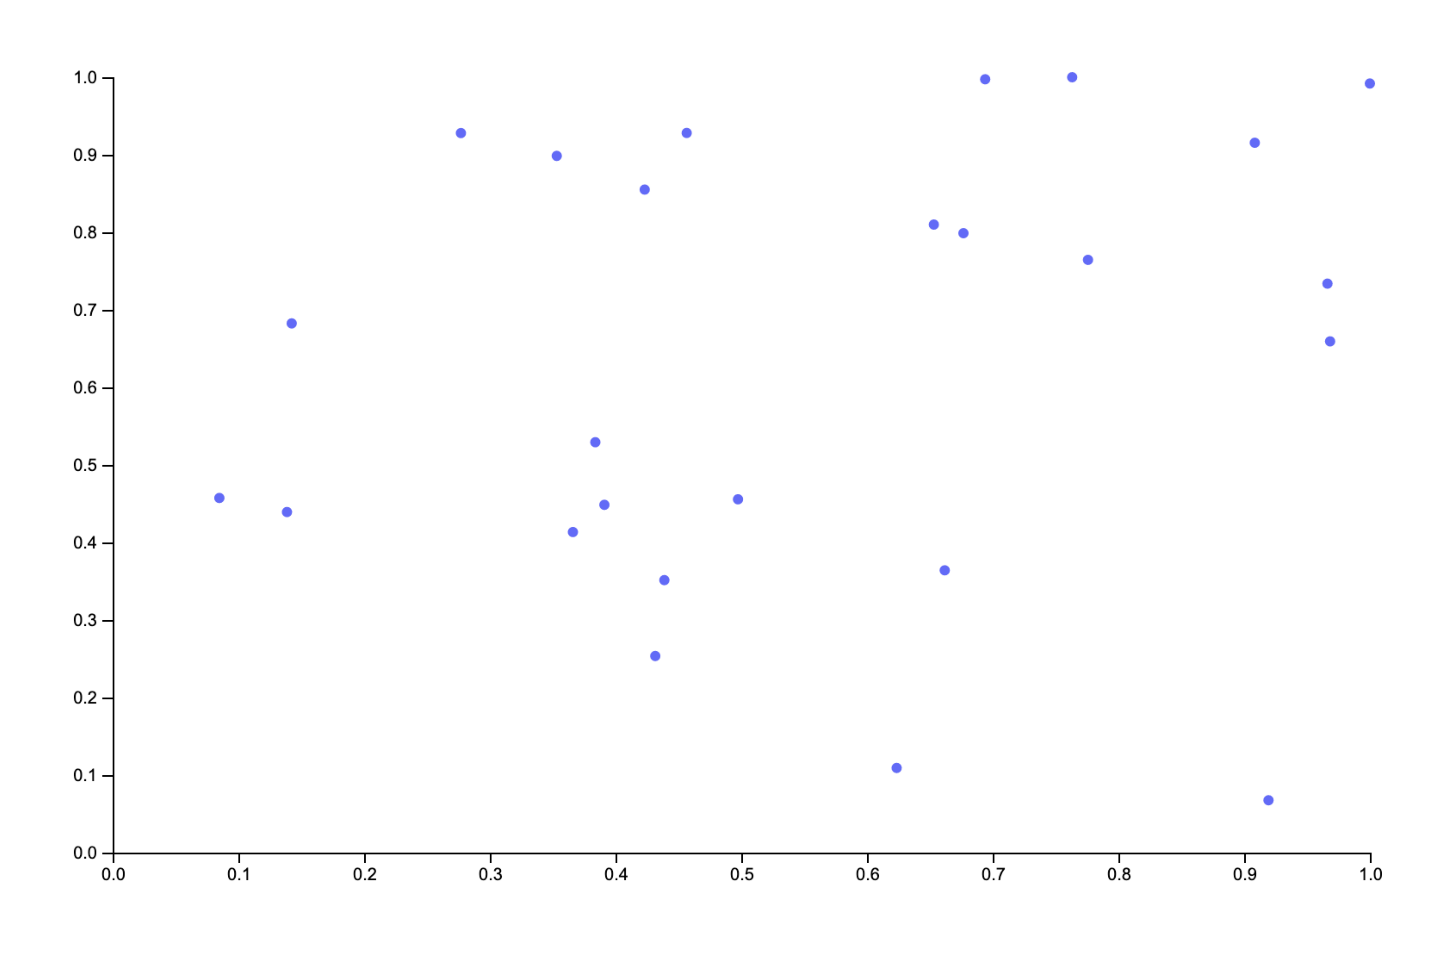

In [3]:

svg = driver.find_element_by_id("container")
driver.set_window_size(svg.size['width']+10,svg.size['height']+20)
svg_coords = svg.location_once_scrolled_into_view 
driver.execute_script('window.scrollTo({}, {});'.format(svg_coords['x'], svg_coords['y']))
driver.save_screenshot("img/scatterplot.png")
driver.set_window_size(rendered_width, rendered_height)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    
from matplotlib import rc_params
plt.rcParams['figure.dpi'] = 300
img = mpimg.imread('img/scatterplot.png')
fig, ax = plt.subplots()
ax.set_axis_off()
imgplot = plt.imshow(img)

### Visual Encodings Comprehension

We can use the fact that all of our data is plotted in the `<g id="symbols">` group to verify that all of the data are plotted.

In [4]:
symbols = driver.find_element_by_id("symbols").find_elements_by_tag_name("circle")
print(f"{len(symbols)} symbols found.")

25 symbols found.


#### Fill, Radius, etc.
Style settings, such as the radius and fill color can be retrieved using attributes, property and css getters.

In [5]:
symbol_sizes = list(set(s.get_attribute("r") for s in symbols))
print(f"found {len(symbol_sizes)} radii {symbol_sizes}")

found 1 radii ['3']


In [6]:
symbol_fill = list(set(s.value_of_css_property("fill") for s in symbols))
print(f"found {len(symbol_fill)} fill color(s): {symbol_fill}")

found 1 fill color(s): ['rgb(100, 100, 255)']


#### Positioning
In a grading context, we want to verify if the proper scale and scale settings where used to position the plot marks. To accomplish this, we calculate the expected positions of each datum independently and compare with the actual positions used in the visualization.

reading in the data...

In [7]:
df = pd.read_csv("../viz/data/data1.csv")
print(df.iloc[1:4,])
print('. . . ')

          x         y
1  0.272064  0.923478
2  0.346943  0.894177
3  0.083364  0.455160
. . . 


To calculate the expected positions of each datum in the visualization, we can call D3 scale functions from Selenium using:

`webdriver.execute_script("//.js call goes here")`

We want each point to be scaled linearly on the `x` and `y` axis.  *Important:* the ranges of our scales will be set to the **retrieved ranges** of the `x` and `y` axis used in the visualization.  This ensures that our data is being scaled in the same dimensions as the visualization. 

Recall that our `x` and `y` ranges come from the size of the special `<path class='domain'>` element found in each axis group. 

In [8]:
x_size = driver.find_element_by_id("x_axis").find_element_by_class_name("domain").size['width']
y_size = driver.find_element_by_id("y_axis").find_element_by_class_name("domain").size['height']
print(f"x-size: {x_size}")
print(f"y-size: {y_size}")

x-size: 730
y-size: 450


Our data domains come from the data:

In [9]:
x_max = np.max(df['x'])
y_max = np.max(df['y'])
print(f"max x-value: {x_max}")
print(f"max y-value: {y_max}")

max x-value: 0.9821456209999999
max y-value: 0.995123317


Our `x` scale call is then:

In [10]:
datum_x =  x_max # 0.9821456209999999, the max value we found for x. 
x_scale_call = f"x_scale = d3.scaleLinear()\
    .range([0, {x_size}]) \
    .domain([0,{x_max}]); \
    return x_scale({datum_x});" 

For a value` = 0.9821456209999999` we would expect the scale to return an `x`-position of `730`. (Ref. the `x-size` variable above)

What does this accomplish?  We are *independently* calling our own 'solution' scale for each data point in the context of the 'submitted' visualization dimensions.  If the submitted visualization uses the correct scale type and specification, then we should be able to calculate matching `x`/`y` positions for each data point that we find.  

In [11]:
x_position = driver.execute_script(x_scale_call)
print(x_position)

730


Let's construct a `y`-scale and sanity check. Note that we invert our range for `y` so that a value of `0` is plotted at the bottom of the visualization. This means we would expect to see `y`-position of `450` for a value of `0`.

In [12]:
datum_y =  0
y_scale_call = f"y_scale = d3.scaleLinear()\
    .range([{y_size}, 0]) \
    .domain([0,{y_max}]); \
    return y_scale({datum_y});" 

In [13]:
y_position = driver.execute_script(y_scale_call)
print(y_position)

450


Wrapping up our scale call to extend its usability:

In [14]:
def d3_scale_linear(webdriver=webdriver.Chrome, \
                datum:float = None, \
                range_min:float = 0.0, \
                range_max:float = None, \
                domain_min:float = 0.0, \
                domain_max:float = None, \
                invert:bool = False)->float:
    """
    Constructs a d3 linear scale and returns position.
    Uses the Selenium webdriver (Chrome) to make a .js call
    Set invert=True to invert the range for the scale (e.g., vertical / y-scales)
    d3 must be loaded in the page being rendered
    """
    range_lower_bound = range_min
    range_upper_bound = range_max
    if invert:
        range_lower_bound = range_max
        range_upper_bound = range_min
    linear_scale_call = f"scale = d3.scaleLinear() \
        .range([{range_lower_bound}, {range_upper_bound}]) \
        .domain([{domain_min},{domain_max}]); \
        return scale({datum});"
    result = webdriver.execute_script(linear_scale_call)
    return result

Confirming our previous results and testing our utility function:

In [15]:
print(d3_scale_linear(driver, datum_x, 0, x_size, 0, x_max))
print(d3_scale_linear(driver, datum_y, 0, y_size, 0, y_max, True))

730
450


We can now calculate the expected positions for all data:

In [16]:
x_coords = []
y_coords = []
for d in df.values:
    x_pos = d3_scale_linear(driver, d[0], 0, x_size, 0, x_max)
    y_pos = d3_scale_linear(driver, d[1], 0, y_size, 0, y_max, True)
    x_coords.append(np.round(x_pos,2))
    y_coords.append(np.round(y_pos,2))
print("Expected symbol positions:")
expected_symbol_positions = pd.DataFrame({'x': x_coords, 'y': y_coords})
print(expected_symbol_positions.iloc[0:4,])
print('. . .')

Expected symbol positions:
        x       y
0  671.14  419.61
1  202.22   32.40
2  257.87   45.65
3   61.96  244.17
. . .


Let's retrieve the actual symbol positions and compare

In [17]:
actual_x_coords = [np.round(np.float(s.get_attribute('cx')),2) for s in symbols]
actual_y_coords = [np.round(np.float(s.get_attribute('cy')),2) for s in symbols]

symbol_compare = pd.DataFrame({'actual_x': actual_x_coords,'expected_x': x_coords, 'actual_y': actual_y_coords, 'expected_y': y_coords})
print(symbol_compare.iloc[0:4,])
print('. . .')

   actual_x  expected_x  actual_y  expected_y
0    671.14      671.14    419.61      419.61
1    202.22      202.22     32.40       32.40
2    257.87      257.87     45.65       45.65
3     61.96       61.96    244.17      244.17
. . .


Adding some simple difference caclulations between the expected and actual values demonstrates that our calculations are rather close!

In [18]:
symbol_compare['x_diff'] = symbol_compare['actual_x'].values - symbol_compare['expected_x'].values
symbol_compare['y_diff'] = symbol_compare['actual_y'].values - symbol_compare['expected_y'].values
print(symbol_compare.iloc[0:4,])
print('. . .')

   actual_x  expected_x  actual_y  expected_y  x_diff  y_diff
0    671.14      671.14    419.61      419.61     0.0     0.0
1    202.22      202.22     32.40       32.40     0.0     0.0
2    257.87      257.87     45.65       45.65     0.0     0.0
3     61.96       61.96    244.17      244.17     0.0     0.0
. . .


### Data-Bindings
Recall when we loaded our data and iterated through earlier:
```
//.js code 
d3.dsv(",", "data/data1.csv", function(d){
    return {
        x: +d.x,
        y: +d.y
    }
})
```
For each datum, we bind `{x: value, y: value}`.  This data is bound when:
we call
```
symbols.selectAll('circle')
    .data(data)
    .enter()
    .append('circle')
    // ...
``` 
Let's take a look at the first circle appended to the visualization:

In [19]:
symbol_data = symbols[0].get_property("__data__")
print(symbol_data)

{'x': 0.902953888, 'y': 0.067206303}


Is this data point scaled correctly in the visualization? 

In [29]:
s0_expected_x_pos = d3_scale_linear(driver, symbol_data['x'],0, x_size, 0, x_max)
s0_expected_y_pos = d3_scale_linear(driver, symbol_data['y'],0, y_size, 0, y_max, True)
print(f"expected coords - x: {s0_expected_x_pos}, y: {s0_expected_y_pos}")
print(f"actual coords - x: {symbols[0].get_attribute('cx')}, y: {symbols[0].get_attribute('cy')}")


expected coords - x: 671.1391102766013, y: 419.60895616316867
actual coords - x: 671.1391102766013, y: 419.60895616316867
